<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp>
                <h1 style="color:blue;text-align:center">Aprendizaje por refuerzo</h1
            </tp>
            <tp>
                <p style="font-size:150%;text-align:center">Procesos de decisión de Markov y Programación dinámica</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

# Objetivo <a class="anchor" id="inicio"></a>

Existen muchísimas aplicaciones muy interesantes de RL. Ellas requieren ambientes relativamente complejos, incluso simulaciones del mundo físico en 3D. En este momento existen muchos ambientes ya implementados en python y de acceso libre, que han sido compilados en los [ambientes de gym](https://gymnasium.farama.org) de la empresa OpenAI. En este notebook bamos a familiarnos un poco con la implementación particular propuesta por esta librería.

Este notebook información de Sanghi (2021), capítulo 2 y sus [notebooks](https://github.com/Apress/deep-reinforcement-learning-python); Sutton R., & Barto, A., (2015), capítulos 3 y 4; y también Winder, P., (2021), capítulo 2 y su [notebook](https://rl-book.com/learn/mdp/code_driven_intro/). 

[Ir a ejercicio 1](#ej1)

# Dependencias

Al iniciar el notebook o reiniciar el kerner, se pueden cargar todas las dependencias de este notebook al correr las siguientes celdas. Este también es el lugar para instalar las dependencias faltantes.

In [1]:
# En linux o mac
#!pip3 install gymnasium[toy-text]
#!pip3 install -r requirements.txt
# En windows
#!py -m pip install -r requirements.txt
#!py -m pip install gymnasium[toy-text]
#!python -m pip install -r requirements.txt
#!python -m pip install gymnasium[toy-text]

**De Python:**

In [5]:
from IPython import display
from time import sleep
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.wrappers import TimeLimit
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random

**Del notebook:**

In [3]:
from ambientes import *
from agentes import Agent
from utils import Episode, gym_interpreter1

%reload_ext autoreload
%autoreload 2

# Secciones

Desarrollaremos la explicación de la siguiente manera:

1. [GridWorld](#gw).
2. [ABC](#abc).
3. [Frozen Lake](#frozen).

---

## Grid World <a class="anchor" id="gw"></a>

([Volver a Ejemplos](#impl))

Un ejemplo muy útil en términos de visualización de Procesos de Decisión Markovianos es el del Grid World, el cual consiste de una rejilla rectangular. Las casillas corresponden a los estados. Hay cuatro acciones: norte, sur, este y oeste, que hacen que el agente se mueva una casilla en la dirección respectiva en la rejilla. Las acciones que sacarían al agente de la rejilla dejan su ubicación sin cambios. Cada acción da como resultado una recompensa de -1. Las casillas (0,0) y (4,4) son estados terminales.

Veamos una implementación *ad hoc* tomada del libro de Sanghi (ver [código](https://github.com/Apress/deep-reinforcement-learning-python/blob/main/chapter3/gridworld.py)):

Observemos algunas características de la clase `GridworldEnv`:

In [6]:
# Instantiate the environment
shape = (4,4)
env = GridworldEnv(shape=shape)
print("Acciones posibles (valores):", env.action_space)
print("Acciones posibles (nombres):", np.vectorize(env.dict_acciones.get)(env.action_space))
print('')
print("Número de acciones posibles:", len(env.action_space))
print('')
a = random.choice(env.action_space)
print("Una acción posible seleccionada al azar:", env.dict_acciones[a])
print('')
print("El estado actual es:", env.state, "que corresponde a la casilla", np.unravel_index(env.state, shape))

Acciones posibles (valores): [0, 1, 2, 3]
Acciones posibles (nombres): ['⬆' '⬅' '⬇' '➡']

Número de acciones posibles: 4

Una acción posible seleccionada al azar: ⬅

El estado actual es: 12 que corresponde a la casilla (3, 0)


Al imprimir el objeto podemos ver el modelo del MDP que ha sido implementado mediante el método `_transition_prob`, el cual define, para cada estado y acción, la siguiente tupla: 

(probabilidad, próximo estado, recompensa, finalizado)

In [7]:
print(env)


--------------------
State: 0 at (0, 0)
Action:⬆
| probability:1.0, new_state:4 at (0, 1), reward:-1, done?:False |
Action:⬅
| probability:1.0, new_state:0 at (0, 0), reward:-1, done?:False |
Action:⬇
| probability:1.0, new_state:0 at (0, 0), reward:-1, done?:False |
Action:➡
| probability:1.0, new_state:1 at (1, 0), reward:-1, done?:False |
--------------------
State: 1 at (0, 1)
Action:⬆
| probability:1.0, new_state:5 at (1, 1), reward:-1, done?:False |
Action:⬅
| probability:1.0, new_state:0 at (0, 0), reward:-1, done?:False |
Action:⬇
| probability:1.0, new_state:1 at (1, 0), reward:-1, done?:False |
Action:➡
| probability:1.0, new_state:2 at (2, 0), reward:-1, done?:False |
--------------------
State: 2 at (0, 2)
Action:⬆
| probability:1.0, new_state:6 at (2, 1), reward:-1, done?:False |
Action:⬅
| probability:1.0, new_state:1 at (1, 0), reward:-1, done?:False |
Action:⬇
| probability:1.0, new_state:2 at (2, 0), reward:-1, done?:False |
Action:➡
| probability:1.0, new_state:3 at 

Uno de los métodos más importantes de la clase es el `step()`, el cual recibe una acción como argumento y, junto con la información del estado actual y el modelo de transiciones, obtiene el estado al que pasa el sistema y devuelve una recompensa. También se obtiene un valor booleano que indica si el estado obtenido es terminal o no:

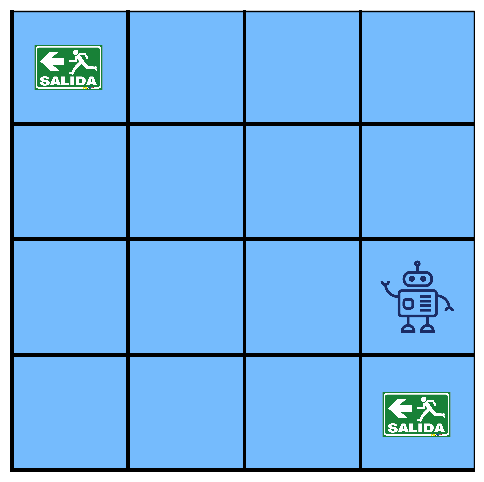

Estado=7 at (3, 1)
Estado=7 at at (3, 1), Recompensa=-1, Finalizado=False


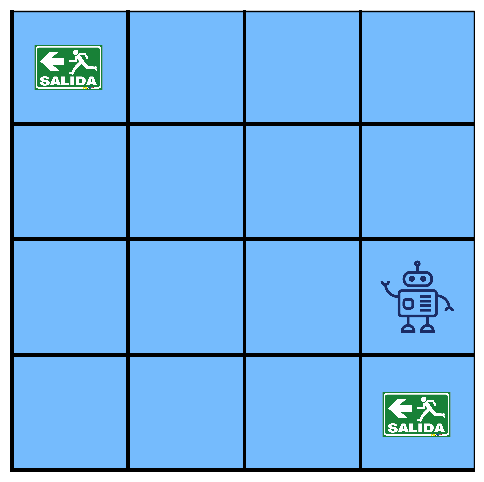

<Axes: >

In [16]:
env = GridworldEnv()
env.render()
Y, X = np.unravel_index(env.state, env.shape)
print(f'Estado={env.state} at ({X}, {Y})')
obs, reward, done = env.step(env.EAST)
Y, X = np.unravel_index(env.state, env.shape)
print(f'Estado={obs} at at ({X}, {Y}), Recompensa={reward}, Finalizado={done}')
env.render()

<a class="anchor" id="ej1"></a>**Ejercicio 1:** 

([Próximo ejercicio](#ej2))

Cree un pequeño script para hacer una caminata aleatoria por la rejilla hasta que el agente llegue a un estado terminal. Encuentre la utlidad (recompensa total) del episodio.

In [17]:
def run_episode():
    total_reward = 0
    while True:
        env.render()
        Y, X = np.unravel_index(env.state, env.shape)
        print(f'Estado={env.state} at ({X}, {Y})')
        action = np.random.choice(env.action_space)
        obs, reward, done = env.step(action)
        total_reward += reward
        Y, X = np.unravel_index(obs, env.shape)
        print(f'Estado={obs} at ({X}, {Y}), Recompensa={reward}, Finalizado={done}')
        if done:
            break
    return total_reward

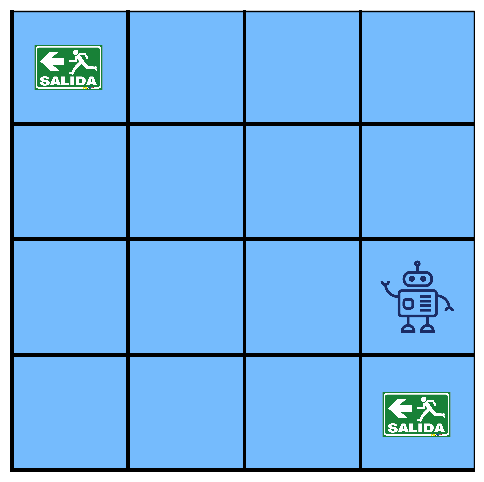

Estado=7 at (3, 1)
Estado=11 at (3, 2), Recompensa=-1, Finalizado=False


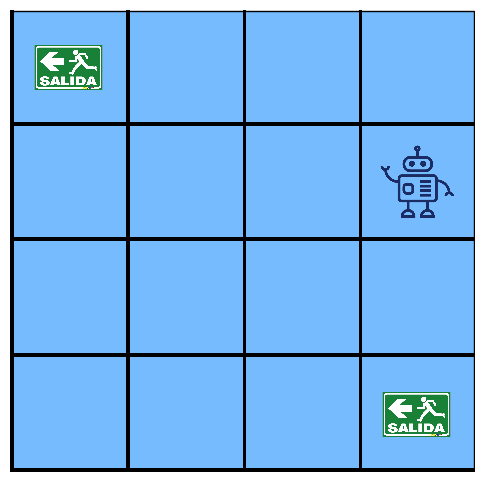

Estado=11 at (3, 2)
Estado=7 at (3, 1), Recompensa=-1, Finalizado=False


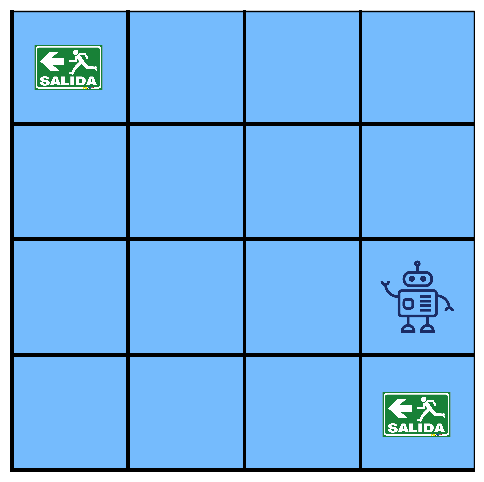

Estado=7 at (3, 1)
Estado=11 at (3, 2), Recompensa=-1, Finalizado=False


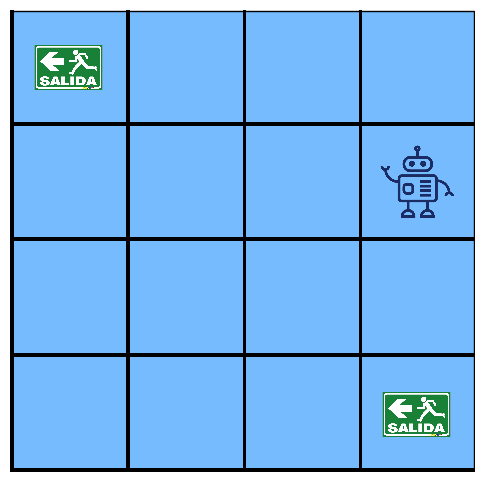

Estado=11 at (3, 2)
Estado=10 at (2, 2), Recompensa=-1, Finalizado=False


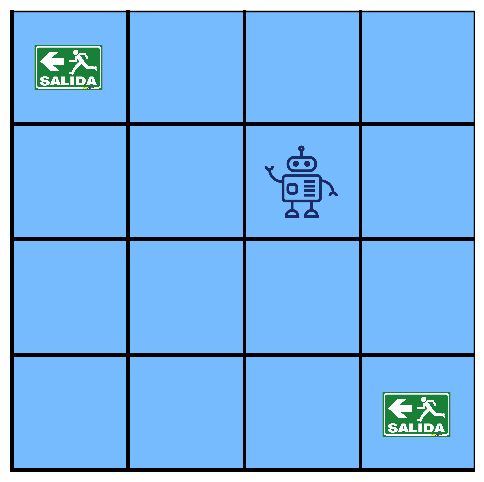

Estado=10 at (2, 2)
Estado=6 at (2, 1), Recompensa=-1, Finalizado=False


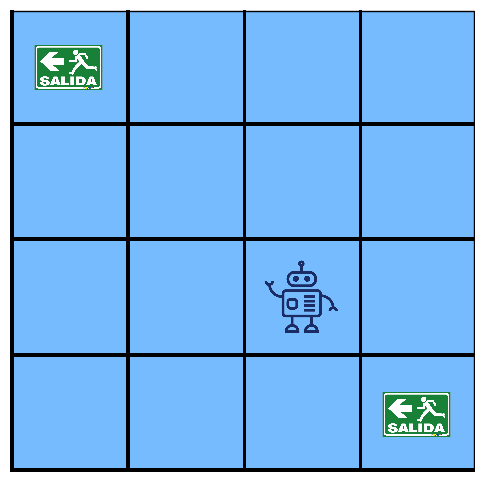

Estado=6 at (2, 1)
Estado=7 at (3, 1), Recompensa=-1, Finalizado=False


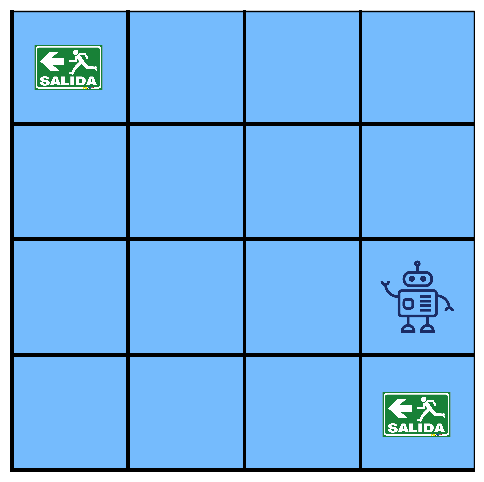

Estado=7 at (3, 1)
Estado=3 at (3, 0), Recompensa=-1, Finalizado=True
Utilidad del episodio: -7


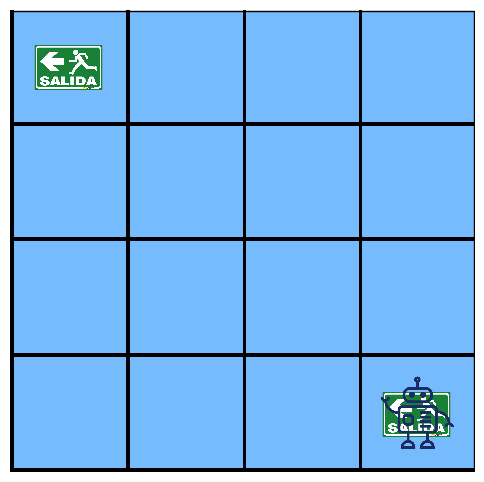

<Axes: >

In [18]:
total_reward = run_episode()
print(f'Utilidad del episodio: {total_reward}')
env.render()

---

## ABC <a class="anchor" id="abc"></a>

([Volver a Ejemplos](#impl))

Un entorno muy sencillo que hemos trabajado en clase es el ABC:

<img src="./imagenes/abc.png" width="600"/>

In [41]:
# Instantiate the environment
env = ABC()
print("Acciones posibles (valores):", env.action_space)
print("Acciones posibles (nombres):", np.vectorize(env.dict_acciones.get)(env.action_space))
print('')
print("Número de acciones posibles:", len(env.action_space))
print('')
a = np.random.choice(env.action_space)
print("Una acción posible seleccionada al azar:", env.dict_acciones[a])
print('')
print("El estado actual es:", env.state, "que corresponde a", env.dict_states[env.state])

Acciones posibles (valores): [0, 1]
Acciones posibles (nombres): ['LEFT' 'RIGHT']

Número de acciones posibles: 2

Una acción posible seleccionada al azar: LEFT

El estado actual es: 0 que corresponde a A


<a class="anchor" id="ej2"></a>**Ejercicio 2:** 

([Anterior ejercicio](#ej1)) ([Próximo ejercicio](#ej3))


Complete el método `set_P` para definir el modelo del MDP el cual define, para cada estado y acción, la siguiente tupla: 

(probabilidad, próximo estado, recompensa, finalizado)

In [42]:
def set_P(self):
    P = {}
    P[self.A] = {a:[] for a in range(self.nA)}
    P[self.B] = {a:[] for a in range(self.nA)}
    P[self.C] = {a:[] for a in range(self.nA)}
    # AQUÍ SU CÓDIGO
    P[self.A][self.LEFT] = [(1.0, self.A, -1, False)] # Lista con una tupla
    P[self.A][self.RIGHT] = [(0.1, self.A, -1, False), (0.9, self.B, -1, False)]   # Lista con dos tuplas
    P[self.B][self.LEFT] = [(1.0, self.A, -1, False)]  # Lista con una tupla
    P[self.B][self.RIGHT] = [(0.1, self.B, -1, False), (0.9, self.C, 10, True)] # Lista con dos tuplas
    # HASTA AQUÍ SU CÓDIGO
    return P
setattr(ABC, 'set_P', set_P)
env = ABC()
print(env)


--------------------
State: A
Action:LEFT
| probability:1.0, new_state:A, reward:-1, done?:False |
Action:RIGHT
| probability:0.1, new_state:A, reward:-1, done?:False |
| probability:0.9, new_state:B, reward:-1, done?:False |
--------------------
State: B
Action:LEFT
| probability:1.0, new_state:A, reward:-1, done?:False |
Action:RIGHT
| probability:0.1, new_state:B, reward:-1, done?:False |
| probability:0.9, new_state:C, reward:10, done?:True |
--------------------
State: C
Action:LEFT
Action:RIGHT


---

## Frozen lake <a class="anchor" id="frozen"></a>

([Volver a Ejemplos](#impl))

Ahora veremos un entorno de gymnasium que se llama [fozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/). El agente debe cruzar un lago congelado de principio a fin sin caer en ningún agujero al caminar. Es posible que el jugador no siempre se mueva en la dirección deseada debido a la naturaleza resbaladiza del lago congelado.

El código fuente del entorno puede encontrarse en: [source code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/frozen_lake.py)



In [32]:
is_slippery = True  # Make False to avoid slipping
env = gym.make('FrozenLake-v1', 
              desc=None, 
              map_name="4x4",
              is_slippery=is_slippery, 
              render_mode='rgb_array')
obs = env.reset()
print("Observacion inicial: ", obs)
print("Número de acciones posibles:", env.action_space.n)
print("Acciones posibles:", env.action_space)
print("Una acción posible seleccionada al azar:", env.action_space.sample())

Observacion inicial:  (0, {'prob': 1})
Número de acciones posibles: 4
Acciones posibles: Discrete(4)
Una acción posible seleccionada al azar: 1


Al igual que en el anterior ambiente, podemos acceder a las probabilidades de transición:

In [20]:
env.P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:

Visualizamos algunas acciones aleatorias del agente en el entorno. Esta vez usamos la clase `Episode` del módulo `utils` y el agente `Agent` del módulo `agentes`:

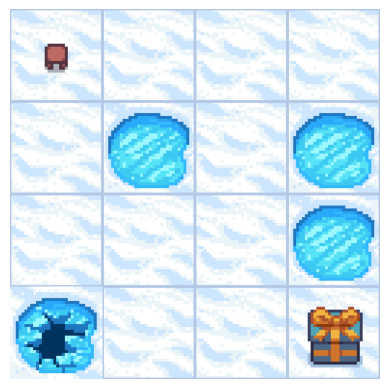

Moviepy - Building video c:\Users\Laura\Downloads\Procesos de decisión markovianos-20231102\frozen_lake/rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Laura\Downloads\Procesos de decisión markovianos-20231102\frozen_lake/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Laura\Downloads\Procesos de decisión markovianos-20231102\frozen_lake/rl-video-episode-0.mp4


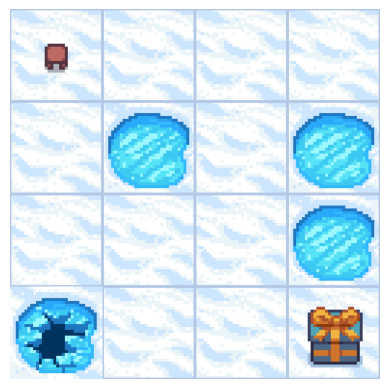

In [21]:
is_slippery = False
size = 4
max_rounds = 50
# Create environment
env = gym.make('FrozenLake-v1', 
               desc=None, 
               map_name="4x4",
               is_slippery=is_slippery, 
               render_mode='rgb_array'
              )
env = TimeLimit(env, max_episode_steps=max_rounds)
# Create agent
parameters = {
    "nS": size*size,
    "nA": env.action_space.n,
    "gamma":0.99,
    "epsilon":0
}
agent = Agent(parameters=parameters)
# Create episode
episodio = Episode(environment=env,\
                   env_name='FrozenLake',\
                   agent=agent,\
                   model_name='Random',\
                   num_rounds=max_rounds, \
                   state_interpreter=gym_interpreter1)
# Visualize
episodio.renderize(to_video=True, file='frozen_lake')

Observe que en la carpeta `frozen_lake/` se crea un video con la anterior visualización del entorno.

<a class="anchor" id="ej3"></a>**Ejercicio 3:** 

([Anterior ejercicio](#ej2))

Adapte el código anterior para crear un video con la visualización del entorno [taxi](https://gymnasium.farama.org/environments/toy_text/taxi/).

Moviepy - Building video c:\Users\Laura\Downloads\Procesos de decisión markovianos-20231102\taxi/rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Laura\Downloads\Procesos de decisión markovianos-20231102\taxi/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Laura\Downloads\Procesos de decisión markovianos-20231102\taxi/rl-video-episode-0.mp4


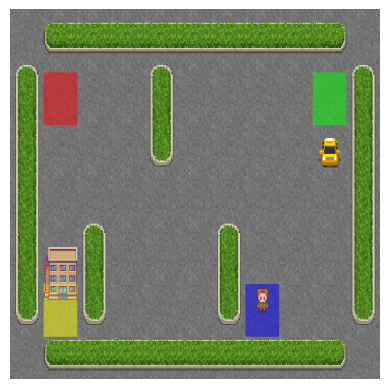

In [40]:
is_slippery = False
max_rounds = 50

# Create environment
env = gym.make('Taxi-v3',  
                render_mode='rgb_array'
                )
env = TimeLimit(env, max_episode_steps=max_rounds)

# Create agent
parameters = {
    "nS": env.observation_space.n,
    "nA": env.action_space.n,
    "gamma": 0.99,
    "epsilon": 0
}
agent = Agent(parameters=parameters)

# Create episode
episodio = Episode(environment=env,
                    env_name='Taxi',
                    agent=agent,
                    model_name='Random',
                    num_rounds=max_rounds,
                    state_interpreter=gym_interpreter1)

# Visualize
episodio.renderize(to_video=True, file='taxi')

Elaborado por: Laura Gonzalez

---

# En este notebook usted aprendió

* Cómo implementar un MDP en python.
* Usar la librería `gym` de OpenAI para cargar entornos.
* Crear un video de la visualización de un entorno.

# Bibliografía

([Volver al inicio](#inicio))

Shanghi, N. (2021) Deep Reinforcement Learning with Python: With PyTorch, TensorFlow and OpenAI Gym. Apress. 

Sutton R., & Barto, A., (2015) Reinforcement Learning: An Introduction, 2nd Edition. A Bradford Book. Series: Adaptive Computation and Machine Learning series. 

Winder, P., (2021) Reinforcement Learning: Industrial Applications of Intelligent Agents. O’Relly.